In [1]:
import EddyDetectionV2 as eddy
import oceanspy as ospy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import SymLogNorm
from tqdm import tqdm
import ast
from matplotlib.animation import FuncAnimation, FFMpegFileWriter
from matplotlib.colors import LinearSegmentedColormap

In [3]:
# Import data #######################################################################################################################
depth = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/Depth_res.nc')['Depth'].sel(Y=slice(70,75)).sel(X=slice(-22,2))
depth_no_nan = depth
depth = depth.where(depth > 0, np.nan)

df = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/Background_var_eddies.nc')
df_OW = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/OW_WMZ.nc')['w_mean_Okubo_Weiss']
#df_OW = df['Okubo_Weiss']
df_OW = df_OW*(1/(10**(-9)))
df_eta = df['Eta']#.rolling(X=5,Y=5,center=True).mean()

# Inner domain
domain_center = [[-20,0],[71,74]]
OW_center = df_OW.sel(X=slice(domain_center[0][0],domain_center[0][1])).sel(Y=slice(domain_center[1][0],domain_center[1][1]))
eta_center = df_eta.sel(X=slice(domain_center[0][0],domain_center[0][1])).sel(Y=slice(domain_center[1][0],domain_center[1][1]))

# Outer domain
eta = df_eta.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-1,domain_center[1][1]+1))
OW = df_OW.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-1,domain_center[1][1]+1))

In [4]:
# Resample data
eta = eta.resample(time='D').mean(dim='time')
eta_center = eta_center.resample(time='D').mean(dim='time')
OW = OW.resample(time='D').mean(dim='time')
OW_center = OW_center.resample(time='D').mean(dim='time')

eta = eta.where(depth > 0, np.nan)
OW = OW.where(depth > 0, np.nan)

In [19]:
with open("eddyCenterpoints_fullYear.txt",'r') as f:
        data = f.read()
        eddyLocation_std = ast.literal_eval(data)

eddyLocation = []
OW_th = -10**(-5)# -0.1*OW_center.std().values
T = len(eta)
pbar = tqdm(total=T, desc="Running eddy centerpoint algorythm")
for i in range(len(eta)):
        eddyLocation.append(eddy.eddyDetection(eta_center[i],OW_center[i],OW_th))
        pbar.update(1)
pbar.close()

Running eddy centerpoint algorythm: 100%|██████████| 365/365 [01:03<00:00,  5.76it/s]


In [20]:
display(len(eddyLocation))

365

In [21]:
len_eddyLoc_max = [len(X[0]) for X in eddyLocation]
len_eddyLoc_std_max = [len(X[0]) for X in eddyLocation_std]

len_eddyLoc_min = [len(X[1]) for X in eddyLocation]
len_eddyLoc_std_min = [len(X[1]) for X in eddyLocation_std]

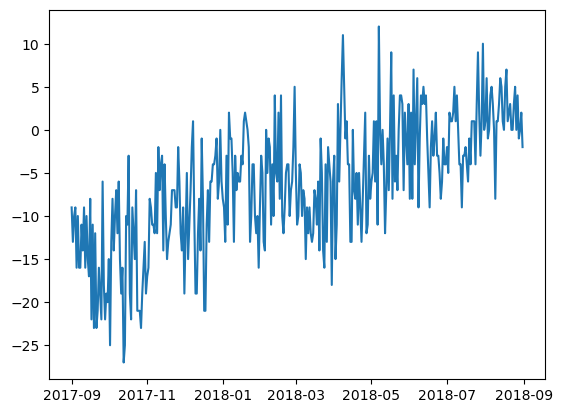

In [22]:
plt.plot(eta.time,np.array(len_eddyLoc_max)-np.array(len_eddyLoc_std_max))

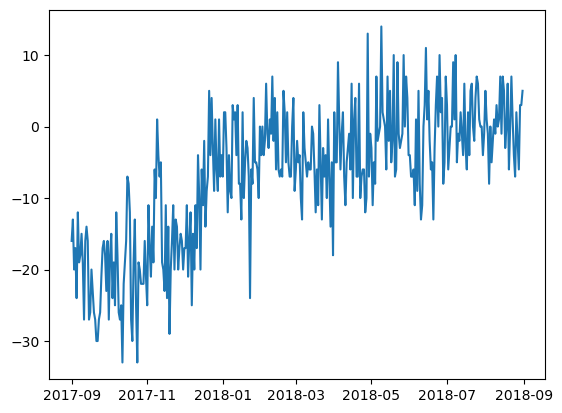

In [16]:
plt.plot(eta.time,np.array(len_eddyLoc_min)-np.array(len_eddyLoc_std_min))

In [23]:
print(r'% diff: ', 100-(np.sum(len_eddyLoc_max)+np.sum(len_eddyLoc_min))/(np.sum(len_eddyLoc_std_max)+np.sum(len_eddyLoc_std_min))*100)

% diff:  11.16459699548858
